In [168]:
from matplotlib.pyplot import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize, rescale
from skimage import color
import scipy.signal
from time import time
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle

%matplotlib inline

In [169]:
def apply_med_filter_2_2(img):
    for i in range(0, len(img), 2):
        for j in range(0, len(img[0]), 2):
            img[i:i+2, j:j+2] = np.median(img[i:i+2, j:j+2])
    return img

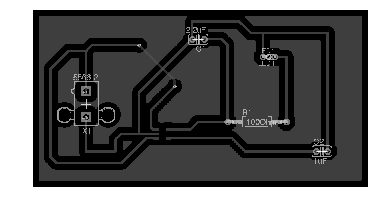

In [170]:
def get_gray_norm_image(path):
    orig_img = imread(path)
    gray_img = color.rgb2gray(orig_img)
    norm_img = gray_img/255.
    return norm_img
        

img = get_gray_norm_image('./pcb_image_2.png')
plt.axis('off')
plt.imshow(img, cmap='gray')

In [171]:
def show_component(h_start=0, h_end=1, w_start=0, w_end=1):
    """
    show component from h_start to h_start, w_start to w_end (input [0, 1])
    """

    plt.axis('off')
    h, w = img.shape
    
    kernel = img[int(h*h_start):int(h*h_end), int(w*w_start):int(w*w_end)]
    plt.imshow(kernel, cmap='gray')
    return kernel

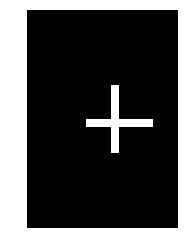

In [172]:
component0_unlabeled = show_component(0.4, 0.66, 0.07, 0.25)
component1_unlabeled = show_component(0.761, 0.836, 0.831, 0.895)
component2_unlabeled = show_component(0.598, 0.671, 0.569, 0.771)
component3_unlabeled = show_component(0.248, 0.288, 0.676, 0.735)
component4_unlabeled = show_component(0.67, 0.73, 0.375, 0.397)

In [173]:
def get_detected(img, component):
    """
    input: image and component patch
    output: best_location (left, upper corner) along with a diagram showing the detected image
    """
    start_time = time()
    best_score, res, best_loc = -1, None, None
    for component in [component, component.T]:
        med = np.median(img)
        signed_img = np.where(img > med, 1, -1)
        signed_component = np.where(component > med, 1, -1)
        m1, n1 = signed_img.shape[:2]
        m2, n2 = signed_component.shape[:2]
        convolved = np.zeros(signed_img.shape)
        for i in range(m1-m2):
            for j in range(n1-n2):
                convolved[i, j] = np.sum(signed_img[i:i+m2, j:j+n2]*signed_component)
        loc = np.argmax(convolved.ravel())
        i, j = loc//n1, loc % n1
        matched = np.zeros(img.shape)
        matched[i:i+m2, j:j+n2] = img[i:i+m2, j:j+n2]
        if (convolved.ravel()[loc] > best_score):
            best_score = convolved.ravel()[loc]
            res = matched
            best_loc =loc
            
    print('Get detected: {} seconds elapsed'.format(time()-start_time))
    return (best_loc//n1, best_loc%n1), res

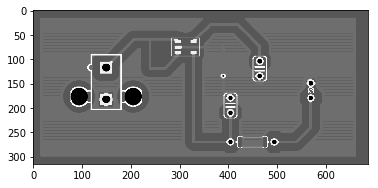

In [174]:
img_2_9 = get_gray_norm_image('./2-9-top.png')
plt.imshow(img_2_9, cmap='gray')

Get detected: 7.2083210945129395 seconds elapsed


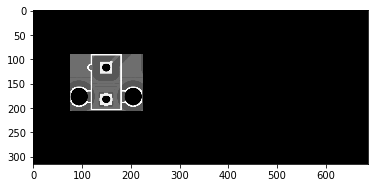

In [175]:
plt.imshow(get_detected(img_2_9, component0_unlabeled)[1], cmap='gray')

Get detected: 3.1692659854888916 seconds elapsed


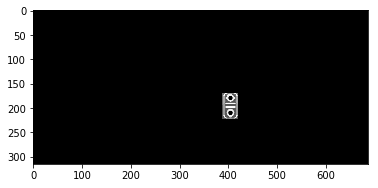

In [176]:
plt.imshow(get_detected(img_2_9, component1_unlabeled)[1], cmap='gray')

Get detected: 3.7603421211242676 seconds elapsed


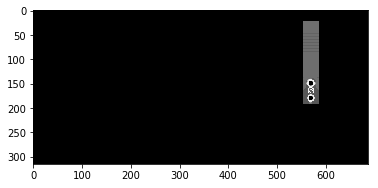

In [177]:
plt.imshow(get_detected(img_2_9, component2_unlabeled)[1], cmap='gray')

Get detected: 2.621943950653076 seconds elapsed


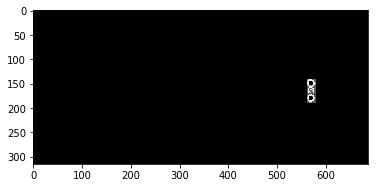

In [178]:
plt.imshow(get_detected(img_2_9, component3_unlabeled)[1], cmap='gray')

Get detected: 2.133552312850952 seconds elapsed


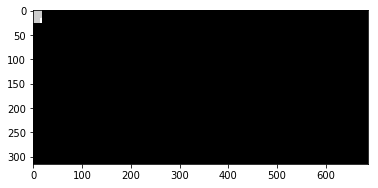

In [179]:
plt.imshow(get_detected(img_2_9, component4_unlabeled)[1], cmap='gray')


# TODO: fix the nodes of the graph.

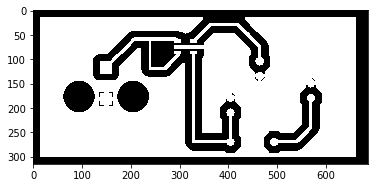

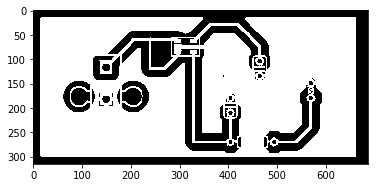

In [180]:
def to_binary(copper_img):
    """
    convert image to binary
    hopefully remove the noise (horizontal bar)
    """
    return np.where(copper_img > np.percentile(copper_img, 5), 1, 0)

copper_img = get_gray_norm_image('./2-9-top-copper.png')
plt.imshow(to_binary(copper_img), cmap='gray')
plt.figure()
plt.imshow(to_binary(img_2_9), cmap='gray')

In [181]:
loc1 = get_detected(img_2_9, component0_unlabeled)[0]
loc2 = get_detected(img_2_9, component1_unlabeled)[0]

Get detected: 7.372976779937744 seconds elapsed
Get detected: 3.1544265747070312 seconds elapsed


In [182]:
center1 = list(loc1)
center1[0] += component0_unlabeled.shape[0]/2
center1[1] += component0_unlabeled.shape[1]/2

center2 = list(loc2)
center2[0] += component1_unlabeled.shape[0]/2
center2[1] += component1_unlabeled.shape[1]/2

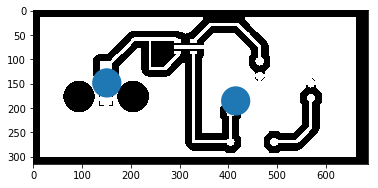

In [185]:
fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(to_binary(copper_img), cmap='gray')
ax.add_patch(Circle(center1[::-1], 30))
ax.add_patch(Circle(center2[::-1], 30))

In [236]:
def traverse_binary_graph(input_img, start_pos):
    """
    Given input image and start position, return an graph with edge traversed (marked red)
    TODO: instead of just traversing wires as edges, incorporate nodes and construct the graph
    """
    start_time = time()
    m, n = input_img.shape
    img = np.zeros((m, n, 3)).astype(int)
    for i in range(m):
        for j in range(n):
            img[i, j] = (0, 0, 0) if input_img[i, j] == 0 else (255, 255, 255)
    
    start_pos = list(map(int, start_pos))
    
    
    queue = []
    queue.append(start_pos)
    img[start_pos[0], start_pos[1]] = (255, 0, 0)
    while queue:
        i, j = queue.pop()
        for ni, nj in [[i-1, j], [i+1, j], [i, j+1], [i, j-1]]:
            if 0 <= ni < m and 0 <= nj < n and np.sum(img[ni, nj]) < 1:
                queue.append((ni, nj))
                img[ni, nj] = (255, 0, 0)
    print('traverse_binary_graph: {} seconds elapsed'.format(time()-start_time))
    return img

traverse_binary_graph: 1.092576026916504 seconds elapsed


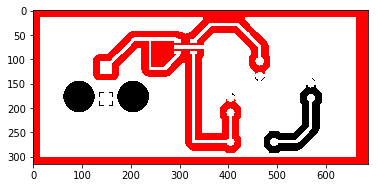

In [237]:
plt.imshow(traverse_binary_graph(to_binary(copper_img), center2), cmap='gray')